## Importing Libraries

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib

## Importing Data

In [15]:

data_dir = "/kaggle/input/classification/dataset_full"

# Function to load data and count total images
def load_data(data_dir):
    total_images = 0
    categories = []

    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)
        if os.path.isdir(category_dir):
            num_images = len(os.listdir(category_dir))
            total_images += num_images
            categories.append((category, num_images))

    print(f"Total Images: {total_images}")
    print("\nCategories and Number of Images:")
    for category, num_images in categories:
        print(f"{category}: {num_images}")

    return total_images, categories

# Load data and count total images
total_images, categories = load_data(data_dir)


Total Images: 5245

Categories and Number of Images:
Streets: 500
Mountains: 500
Building: 500
Sea: 500
Forest: 2745
Glacier: 500


## Data Analysis

Total Categories: 6
Total Images: 5245

Number of Images per Category:
Streets: 500
Mountains: 500
Building: 500
Sea: 500
Forest: 2745
Glacier: 500


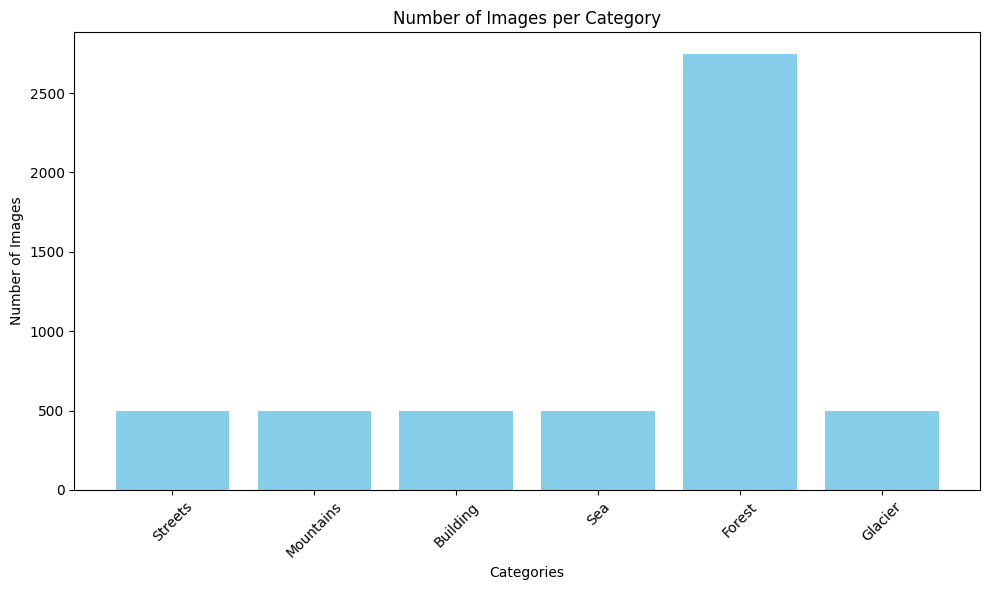

In [16]:
def perform_data_analysis(data_dir):
    categories = []
    num_images_per_category = []

    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)
        if os.path.isdir(category_dir):
            categories.append(category)
            num_images = len(os.listdir(category_dir))
            num_images_per_category.append(num_images)

    total_categories = len(categories)
    total_images = sum(num_images_per_category)
    print(f"Total Categories: {total_categories}")
    print(f"Total Images: {total_images}")
    print("\nNumber of Images per Category:")
    for category, num_images in zip(categories, num_images_per_category):
        print(f"{category}: {num_images}")

    plt.figure(figsize=(10, 6))
    plt.bar(categories, num_images_per_category, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    sample_image_path = os.path.join(data_dir, categories[0], os.listdir(os.path.join(data_dir, categories[0]))[0])
    sample_image = cv2.imread(sample_image_path)
    img_size = sample_image.shape[:2] 

    return total_categories, num_images_per_category, img_size

# Perform data analysis and get image size
total_categories, num_images_per_category, img_size = perform_data_analysis(data_dir)


##  Class Balancing

In [17]:

num_samples_per_category = 500  

def load_and_balance_data(data_dir, num_samples_per_category):
    balanced_images = []
    balanced_labels = []
    categories = os.listdir(data_dir)

    for category in categories:
        category_dir = os.path.join(data_dir, category)
        category_images = []
        for img_name in os.listdir(category_dir)[:num_samples_per_category]:
            img_path = os.path.join(category_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size) 
            category_images.append(image)

        balanced_images.extend(category_images)
        balanced_labels.extend([category] * len(category_images))

    balanced_images = np.array(balanced_images)
    balanced_labels = np.array(balanced_labels)

    return balanced_images, balanced_labels


balanced_images, balanced_labels = load_and_balance_data(data_dir, num_samples_per_category)
print(f"Balanced Images Shape: {balanced_images.shape}, Balanced Labels Shape: {balanced_labels.shape}")


Balanced Images Shape: (3000, 150, 150, 3), Balanced Labels Shape: (3000,)


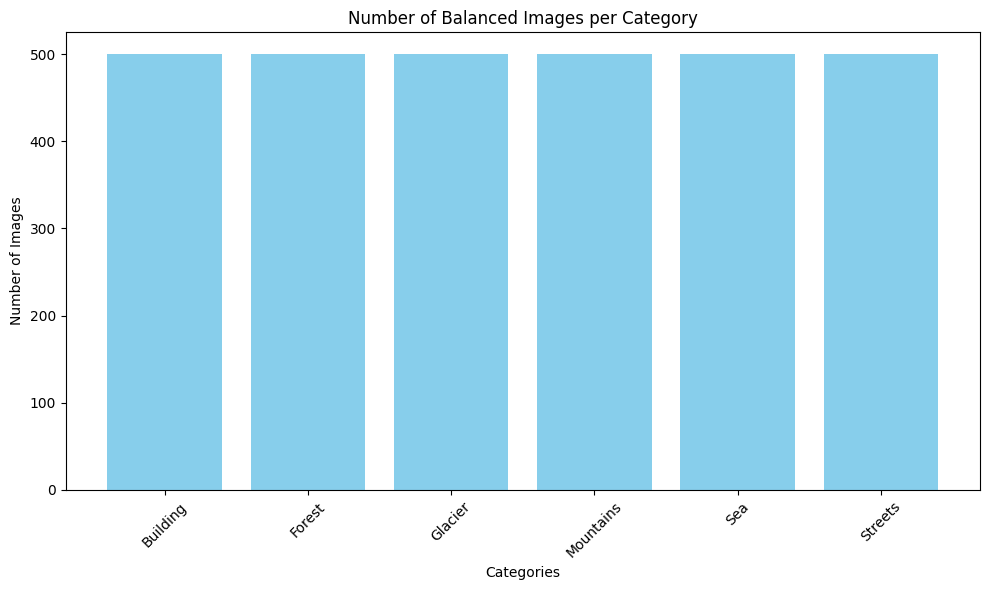

In [18]:
plt.figure(figsize=(10, 6))
unique_categories, counts = np.unique(balanced_labels, return_counts=True)
plt.bar(unique_categories, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Balanced Images per Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Creating Different Feature Sets

In [19]:
# Feature Set 1: Histogram features
def histogram_features(images):
    features = []
    for image in images:
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        features.append(hist.flatten())
    return np.array(features)

# Feature Set 2: Histogram + Grayscale features
def histogram_gray_features(images):
    features = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        gray_flat = gray.flatten()
        features.append(np.concatenate((hist.flatten(), gray_flat)))
    return np.array(features)

# Feature Set 3: Histogram + Grayscale + Edge features
def histogram_gray_edge_features(images):
    features = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        edges = cv2.Canny(gray, 100, 200)
        edge_flat = edges.flatten()
        gray_flat = gray.flatten()
        features.append(np.concatenate((hist.flatten(), gray_flat, edge_flat)))
    return np.array(features)

feature_set1 = histogram_features(balanced_images)
feature_set2 = histogram_gray_features(balanced_images)
feature_set3 = histogram_gray_edge_features(balanced_images)

print(f"Feature Set 1 Shape: {feature_set1.shape}")
print(f"Feature Set 2 Shape: {feature_set2.shape}")
print(f"Feature Set 3 Shape: {feature_set3.shape}")


Feature Set 1 Shape: (3000, 256)
Feature Set 2 Shape: (3000, 22756)
Feature Set 3 Shape: (3000, 45256)


## Dimensionality Reduction with PCA

In [20]:
from sklearn.decomposition import PCA

def apply_pca(features, n_components):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features, pca


n_components = 100


reduced_feature_set2, pca_set2 = apply_pca(feature_set2, n_components)
print(f"Feature Set 2 after PCA Shape: {reduced_feature_set2.shape}")

reduced_feature_set3, pca_set3 = apply_pca(feature_set3, n_components)
print(f"Feature Set 3 after PCA Shape: {reduced_feature_set3.shape}")


Feature Set 2 after PCA Shape: (3000, 100)
Feature Set 3 after PCA Shape: (3000, 100)


## Model Training and Evaluation on Feature Set 1

In [21]:

X_train_fs1, X_test_fs1, y_train_fs1, y_test_fs1 = train_test_split(feature_set1, balanced_labels, test_size=0.2, random_state=42)

classifier_fs1 = RandomForestClassifier(random_state=42)
classifier_fs1.fit(X_train_fs1, y_train_fs1)


y_pred_fs1 = classifier_fs1.predict(X_test_fs1)
accuracy_fs1 = accuracy_score(y_test_fs1, y_pred_fs1)
print("Feature Set 1 - Accuracy:", accuracy_fs1)
print("Feature Set 1 - Classification Report:\n", classification_report(y_test_fs1, y_pred_fs1))


Feature Set 1 - Accuracy: 0.495
Feature Set 1 - Classification Report:
               precision    recall  f1-score   support

    Building       0.33      0.32      0.33        96
      Forest       0.69      0.89      0.78        91
     Glacier       0.55      0.52      0.53        95
   Mountains       0.42      0.40      0.41        99
         Sea       0.40      0.36      0.37       101
     Streets       0.53      0.51      0.52       118

    accuracy                           0.49       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.48      0.49      0.49       600



## Model Training and Evaluation on Feature Set 2 (after PCA)

In [22]:

X_train_fs2, X_test_fs2, y_train_fs2, y_test_fs2 = train_test_split(reduced_feature_set2, balanced_labels, test_size=0.2, random_state=42)


classifier_fs2 = RandomForestClassifier(random_state=42)
classifier_fs2.fit(X_train_fs2, y_train_fs2)


y_pred_fs2 = classifier_fs2.predict(X_test_fs2)
accuracy_fs2 = accuracy_score(y_test_fs2, y_pred_fs2)
print("Feature Set 2 after PCA - Accuracy:", accuracy_fs2)
print("Feature Set 2 after PCA - Classification Report:\n", classification_report(y_test_fs2, y_pred_fs2))


Feature Set 2 after PCA - Accuracy: 0.5166666666666667
Feature Set 2 after PCA - Classification Report:
               precision    recall  f1-score   support

    Building       0.44      0.43      0.43        96
      Forest       0.64      0.84      0.72        91
     Glacier       0.47      0.54      0.50        95
   Mountains       0.49      0.51      0.50        99
         Sea       0.39      0.34      0.36       101
     Streets       0.65      0.49      0.56       118

    accuracy                           0.52       600
   macro avg       0.51      0.52      0.51       600
weighted avg       0.52      0.52      0.51       600



## Model Training and Evaluation on Feature Set 3 (after PCA)

In [23]:

X_train_fs3, X_test_fs3, y_train_fs3, y_test_fs3 = train_test_split(reduced_feature_set3, balanced_labels, test_size=0.2, random_state=42)

classifier_fs3 = RandomForestClassifier(random_state=42)
classifier_fs3.fit(X_train_fs3, y_train_fs3)

y_pred_fs3 = classifier_fs3.predict(X_test_fs3)
accuracy_fs3 = accuracy_score(y_test_fs3, y_pred_fs3)
print("Feature Set 3 after PCA - Accuracy:", accuracy_fs3)
print("Feature Set 3 after PCA - Classification Report:\n", classification_report(y_test_fs3, y_pred_fs3))


Feature Set 3 after PCA - Accuracy: 0.525
Feature Set 3 after PCA - Classification Report:
               precision    recall  f1-score   support

    Building       0.48      0.43      0.45        96
      Forest       0.66      0.95      0.78        91
     Glacier       0.45      0.47      0.46        95
   Mountains       0.48      0.54      0.51        99
         Sea       0.38      0.30      0.33       101
     Streets       0.64      0.51      0.57       118

    accuracy                           0.53       600
   macro avg       0.51      0.53      0.52       600
weighted avg       0.52      0.53      0.51       600



## Comparison of Results from Different Feature Sets

In [25]:


print("Feature Set 1 - Accuracy:", accuracy_fs1)
print("Feature Set 2 after PCA - Accuracy:", accuracy_fs2)
print("Feature Set 3 after PCA - Accuracy:", accuracy_fs3)


Feature Set 1 - Accuracy: 0.495
Feature Set 2 after PCA - Accuracy: 0.5166666666666667
Feature Set 3 after PCA - Accuracy: 0.525


## Save the model to a file

In [28]:
model_filename_fs3 = 'random_forest_model_fs3.pkl'
joblib.dump(classifier_fs3, model_filename_fs3)
print(f"Model saved as {model_filename_fs3}")

Model saved as random_forest_model_fs3.pkl
